# Dataset


Se usara el `Large Movie Review Dataset` (IMDB) desarrollado por [Andrew L. Maas](http://ai.stanford.edu/~amaas/), que contiene 50,000 reviews de películas, etiquetadas por sentimiento (positivo o negativo). Este es usado para tareas de procesamiento de lenguaje natural, o analisis de texto. Este dataset puede ser usado para clasificación binaria. Teniendo 25,000 datos para training y 25,000 datos para prueba. Para mayor información revisa el siguiente enlace: https://ai.stanford.edu/~amaas/data/sentiment/ 

**Nota**: Si vas utilizar este dataset para algún trabajo, no te olvide de citar al los autores 

In [2]:
pip install nltk

  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434681 sha256=9565d384b6d0e47aeb97f5337fd0f94906f0d3ec98819314f2ba34e6ec31bd93
  Stored in directory: c:\users\paul\appdata\local\pip\cache\wheels\45\6c\46\a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk



## Libreria & Load Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd
import string
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df


In [3]:
train_raw, test_raw = download_and_load_datasets()

## Información del Train Set & Test Set

In [4]:
train_raw.info()
#utilizaremos polaridad y sentence
# sentiment es un dato del 1 al 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  object
 2   polarity   25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [5]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  object
 2   polarity   25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [6]:
i_sent = 15569
print("Imprimiendo una sentencia de prueba %d"%(i_sent))
print("||%s||"%(train_raw['sentence'][i_sent]))

Imprimiendo una sentencia de prueba 15569
||One more of extremely unprofessional movies about computer programmers.<br /><br />Looks authors of that movie don't know real specific of programmers world.<br /><br />20 top programmers in the world, program which have own satellites (for what?), program which using satellite freq., somebody kill somebody to steal the codes (why?) and much more of stupid moments at this movie.<br /><br />Peoples who not programmers not will see something awful at that movie, because not professionals on this. But peoples will see not real things.<br /><br />Programmers will find that movie odd and awful - because lots of moments inside movie is not RELATED real life (why movie not scifi in this case?).||


In [7]:
train_raw.head()
#tarea: crear un modelo de clasificación para análisis de sentimiento

,sentence,sentiment,polarity
0,I rented this movie and watched it 20 times be...,10,1
1,I just watched I. Q. again tonight and had for...,9,1
2,Having no knowledge of this film prior to seei...,9,1
3,Page 3 is most definitely a very enthralling a...,8,1
4,CAMILLE 2000 <br /><br />Aspect ratio: 2.35:1 ...,4,0


# Limpieza del Dataset

Se debe realizar una limpieza a las oraciones, eliminando caracteres especiales (comas, puntos, puntos y comas, números, signo de interrogación, signo de adziración, comillas simples, comillas dobles, números, etc)

In [8]:
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

In [9]:
# remover numeros y simbolos de puntuación de las oraciones
# columna "sentence" -> columna "sentence_without_punctuation"

train_raw['sentence_without_punctuation'] = train_raw['sentence'].apply(lambda x: remove_punct(x))
test_raw['sentence_without_punctuation'] = test_raw['sentence'].apply(lambda x: remove_punct(x))

In [10]:
train_raw.head()

,sentence,sentiment,polarity,sentence_without_punctuation
0,I rented this movie and watched it 20 times be...,10,1,I rented this movie and watched it times befo...
1,I just watched I. Q. again tonight and had for...,9,1,I just watched I Q again tonight and had forgo...
2,Having no knowledge of this film prior to seei...,9,1,Having no knowledge of this film prior to seei...
3,Page 3 is most definitely a very enthralling a...,8,1,Page is most definitely a very enthralling an...
4,CAMILLE 2000 <br /><br />Aspect ratio: 2.35:1 ...,4,0,CAMILLE br br Aspect ratio Panavisionbr br S...


In [11]:
# remover stop words como "http, www" de las oraciones

train_raw['sentence_without_stop_words'] = train_raw['sentence_without_punctuation'].str.replace('http\S+|www.\S+', '', case=False)
test_raw['sentence_without_stop_words'] = test_raw['sentence_without_punctuation'].str.replace('http\S+|www.\S+', '', case=False)

In [12]:
train_raw.head()

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words
0,I rented this movie and watched it 20 times be...,10,1,I rented this movie and watched it times befo...,I rented this movie and watched it times befo...
1,I just watched I. Q. again tonight and had for...,9,1,I just watched I Q again tonight and had forgo...,I just watched I Q again tonight and had forgo...
2,Having no knowledge of this film prior to seei...,9,1,Having no knowledge of this film prior to seei...,Having no knowledge of this film prior to seei...
3,Page 3 is most definitely a very enthralling a...,8,1,Page is most definitely a very enthralling an...,Page is most definitely a very enthralling an...
4,CAMILLE 2000 <br /><br />Aspect ratio: 2.35:1 ...,4,0,CAMILLE br br Aspect ratio Panavisionbr br S...,CAMILLE br br Aspect ratio Panavisionbr br S...


# Tokenization

Tokenización es el proceso de generar una lista de palabras a partir de una oración. En general, consistiría, unicamente, en crear esta lista usando los espaciones en blanco como separadores. Por ejemplo:

```
'Viva el diplomado en data science' -> ['Viva', 'el, 'diplomado', 'en', 'data', 'science']
```
Pero, las oraciones pueden contener palabras extrañas e innecesarias para el aprendizaje como hashtags (*#CuidaTuSalud*, *#QuedateEnCasa*, etc) o nombres de usuario (*@VivaElPeru*, *@marbramen*, etc). Entonces estas palabras extrañas deben ser removidas. Por otro lado, para nosotros, palabras como: "*Facebook*", "*facebook*", "*faCeBoOk*" son indiferentes, pero para el modelo aprendizaje representaría tres palabras diferentes, por ende, tres word embeddings distintos. Por tanto, todas las palabras deben ser convertidas a minúsculas o mayúsculas. Otro detalle es que palabras como "*juegaaaaaaa*" y "*juega*" son lo mismo, pero el modelo las considera diferentes. Este tipo palabras también deben ser consideradas en el proceso.

Para crear este proceso, existe distintas librerias. Para este trabajo se usa la librería [Natural Language Toolkit](http://www.nltk.org/), en especial, la función de tokenizador para tweets, llamada [TweetTokenizer](https://www.nltk.org/api/nltk.tokenize.html). Por ejemplo, en su manera más básica sería:

```
>>> from nltk.tokenize import TweetTokenizer
>>> tknzr = TweetTokenizer()
>>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
>>> tknzr.tokenize(s0)
['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
```
Pero para separar handles, reducir el tamaño de palabras (*juegaaaa* -> *juega*)y convertir mayúsculas a minúsculas, se usa *string_handles*, *reduce_len* y *preserve_case*. Para mayor detalle revisar 
la [clase TweetTokenizer](https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer).

```
>>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
>>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
>>> tknzr.tokenize(s1)
[':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
```



In [13]:
tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

In [14]:
train_raw['tokens'] = train_raw['sentence_without_stop_words'].apply(tt.tokenize)
test_raw['tokens'] = test_raw['sentence_without_stop_words'].apply(tt.tokenize)

In [15]:
train_raw.head()

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words,tokens
0,I rented this movie and watched it 20 times be...,10,1,I rented this movie and watched it times befo...,I rented this movie and watched it times befo...,"[i, rented, this, movie, and, watched, it, tim..."
1,I just watched I. Q. again tonight and had for...,9,1,I just watched I Q again tonight and had forgo...,I just watched I Q again tonight and had forgo...,"[i, just, watched, i, q, again, tonight, and, ..."
2,Having no knowledge of this film prior to seei...,9,1,Having no knowledge of this film prior to seei...,Having no knowledge of this film prior to seei...,"[having, no, knowledge, of, this, film, prior,..."
3,Page 3 is most definitely a very enthralling a...,8,1,Page is most definitely a very enthralling an...,Page is most definitely a very enthralling an...,"[page, is, most, definitely, a, very, enthrall..."
4,CAMILLE 2000 <br /><br />Aspect ratio: 2.35:1 ...,4,0,CAMILLE br br Aspect ratio Panavisionbr br S...,CAMILLE br br Aspect ratio Panavisionbr br S...,"[camille, br, br, aspect, ratio, panavisionbr,..."


# Analisis

En esta sección realizaras un breve analisis de los datos, considerando el tamaño de las oraciones y respondiendo algunas preguntas. **Nota**: En el modulo 1 aprendiste Pandas, así que te será fácil responder estas preguntas.

In [16]:
# esto aumentará una columna con el tamaño de cada oración 
train_raw['len_tokens'] = train_raw['tokens'].str.len() 

In [17]:
train_raw.head(5)

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words,tokens,len_tokens
0,I rented this movie and watched it 20 times be...,10,1,I rented this movie and watched it times befo...,I rented this movie and watched it times befo...,"[i, rented, this, movie, and, watched, it, tim...",95
1,I just watched I. Q. again tonight and had for...,9,1,I just watched I Q again tonight and had forgo...,I just watched I Q again tonight and had forgo...,"[i, just, watched, i, q, again, tonight, and, ...",312
2,Having no knowledge of this film prior to seei...,9,1,Having no knowledge of this film prior to seei...,Having no knowledge of this film prior to seei...,"[having, no, knowledge, of, this, film, prior,...",196
3,Page 3 is most definitely a very enthralling a...,8,1,Page is most definitely a very enthralling an...,Page is most definitely a very enthralling an...,"[page, is, most, definitely, a, very, enthrall...",199
4,CAMILLE 2000 <br /><br />Aspect ratio: 2.35:1 ...,4,0,CAMILLE br br Aspect ratio Panavisionbr br S...,CAMILLE br br Aspect ratio Panavisionbr br S...,"[camille, br, br, aspect, ratio, panavisionbr,...",232


### Histograma de la longitud de oración (3 puntos)

Plotea un histograma del número de tokens por oraciones (columna 'len_sentence_tokenized'). Pandas, este brinda una función **hist()**, la puedes usar para mostrar un histograma de una columna en específico. Para mayor información revisar [pandas.DataFrame.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html)

In [18]:
topTokens=train_raw.sort_values('len_tokens',ascending=False)
topTokens.head()

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words,tokens,len_tokens
12580,Match 1: Tag Team Table Match Bubba Ray and Sp...,9,1,Match Tag Team Table Match Bubba Ray and Spik...,Match Tag Team Table Match Bubba Ray and Spik...,"[match, tag, team, table, match, bubba, ray, a...",2460
16473,Titanic directed by James Cameron presents a f...,9,1,Titanic directed by James Cameron presents a f...,Titanic directed by James Cameron presents a f...,"[titanic, directed, by, james, cameron, presen...",1829
2948,**Attention Spoilers**<br /><br />First of all...,9,1,Attention Spoilersbr br First of all let me sa...,Attention Spoilersbr br First of all let me sa...,"[attention, spoilersbr, br, first, of, all, le...",1822
24454,By now you've probably heard a bit about the n...,10,1,By now youve probably heard a bit about the ne...,By now youve probably heard a bit about the ne...,"[by, now, youve, probably, heard, a, bit, abou...",1721
14281,*!!- SPOILERS - !!*<br /><br />Before I begin ...,10,1,SPOILERS br br Before I begin this let me sa...,SPOILERS br br Before I begin this let me sa...,"[spoilers, br, br, before, i, begin, this, let...",1577


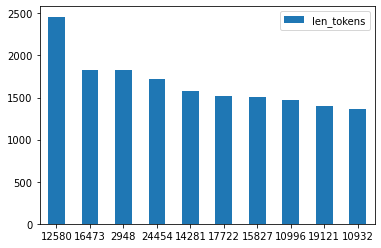

In [19]:
ax=topTokens[:10].plot.bar( y='len_tokens', rot=0)

### Sentencia más/menos larga (3 puntos)

Imprime la sentencia con el mayor/menor número de tokens (`sentence_max_len`/`sentence_min_len`). Estos valores `max_len` (máximo número de tokens), `min_len` (mínimo número de tokens), serán utiles para elegir la longitud de sentencia de entrada del modelo.

In [20]:
#MENOR
topTokens=train_raw.sort_values('len_tokens',ascending=True)
topTokens.head()
#topTokens['sentence'][0]

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words,tokens,len_tokens
20784,I wouldn't rent this one even on dollar rental...,1,0,I wouldnt rent this one even on dollar rental ...,I wouldnt rent this one even on dollar rental ...,"[i, wouldnt, rent, this, one, even, on, dollar...",10
4528,This movie is terrible but it has some good ef...,3,0,This movie is terrible but it has some good ef...,This movie is terrible but it has some good ef...,"[this, movie, is, terrible, but, it, has, some...",10
3003,You'd better choose Paul Verhoeven's even if y...,3,0,Youd better choose Paul Verhoevens even if you...,Youd better choose Paul Verhoevens even if you...,"[youd, better, choose, paul, verhoevens, even,...",11
24587,Ming The Merciless does a little Bardwork and ...,1,0,Ming The Merciless does a little Bardwork and ...,Ming The Merciless does a little Bardwork and ...,"[ming, the, merciless, does, a, little, bardwo...",12
6576,Adrian Pasdar is excellent is this film. He ma...,9,1,Adrian Pasdar is excellent is this film He mak...,Adrian Pasdar is excellent is this film He mak...,"[adrian, pasdar, is, excellent, is, this, film...",12


In [21]:
#MAYOR
topTokens=train_raw.sort_values('len_tokens',ascending=False)
topTokens.head()
#topTokens['sentence'][0]

,sentence,sentiment,polarity,sentence_without_punctuation,sentence_without_stop_words,tokens,len_tokens
12580,Match 1: Tag Team Table Match Bubba Ray and Sp...,9,1,Match Tag Team Table Match Bubba Ray and Spik...,Match Tag Team Table Match Bubba Ray and Spik...,"[match, tag, team, table, match, bubba, ray, a...",2460
16473,Titanic directed by James Cameron presents a f...,9,1,Titanic directed by James Cameron presents a f...,Titanic directed by James Cameron presents a f...,"[titanic, directed, by, james, cameron, presen...",1829
2948,**Attention Spoilers**<br /><br />First of all...,9,1,Attention Spoilersbr br First of all let me sa...,Attention Spoilersbr br First of all let me sa...,"[attention, spoilersbr, br, first, of, all, le...",1822
24454,By now you've probably heard a bit about the n...,10,1,By now youve probably heard a bit about the ne...,By now youve probably heard a bit about the ne...,"[by, now, youve, probably, heard, a, bit, abou...",1721
14281,*!!- SPOILERS - !!*<br /><br />Before I begin ...,10,1,SPOILERS br br Before I begin this let me sa...,SPOILERS br br Before I begin this let me sa...,"[spoilers, br, br, before, i, begin, this, let...",1577


In [22]:
mayorTokens=2460
menorTokens=10

In [23]:
## codifica aqui encuentra el valor de max_len y sentence_max_len
max_len = 2469
sentence_max_len = 'I wouldnt rent this one even on dollar rental...	' 

print("La sentencia más larga es:")
print('\n' + sentence_max_len + '\n')
print("Conteniendo: %d tokens"%(max_len))


La sentencia más larga es:

I wouldnt rent this one even on dollar rental...	

Conteniendo: 2469 tokens


In [24]:
## codifica aqui encuentra el valor de min_len y sentence_min_len
min_len = 10
sentence_min_len = 'Match 1: Tag Team Table Match Bubba Ray and Sp...'

print("La sentencia mínima de tokens es:")
print('\n' + sentence_min_len + '\n')
print("Conteniendo: %d tokens"%(min_len))


La sentencia mínima de tokens es:

Match 1: Tag Team Table Match Bubba Ray and Sp...

Conteniendo: 10 tokens


# Definición del diccionario y de indices

Debido a que cualquier lenguaje contiene un número enorme de tokens, se debe limitar este valor. En general se elige las ***N*** tokens más frecuente, esta variable es: ***max_words***. Además, se debe elegir el tamaño de las oraciones de la entrada, se llama esta variable: ***max_len***. Por tanto, oraciones con un número de tokens mayor a ***max_len*** serán cortadas, y oraciones con un número de tokens menor a ***max_len***, se les aumentará padding. 

Por otro lado, cada token igual debe ser representada por un único número, que representa su entrada en la matriz de embeddings. El 0 representaría padding.

```
['padding', 'cuida', 'tu', 'salud'] -> [0, 69, 24, 12]
```

**Nota**: Recuerda tu elegir el valor de **max_words** y **max_len** usando la anterior sección.

Recuerda sustentar tu respuesta.

 ESCRIBE AQUI PORQUE ELEGISTE EL VALOR DE max_len y max_words

### Codigo (10 puntos)

In [88]:
## CODEA AQUI, DEFINE TU ESTOS VALORES 
max_len = 500 # longitud de la secuencia
max_words = 5000  # tamaño del diccionario 

max_review_length =max_len
top_words =max_words
X_train=0
Y_train=0
X_test=0
Y_test=0

## Generación de Indices

In [89]:
# convertir a array numpy necesario para el procesamiento
#X_train_temp = train_raw['tokens'].to_numpy()
#X_test = train_raw['polarity'].to_numpy()

#Y_train_temp = test_raw['tokens'].to_numpy()
#Y_test = test_raw['polarity'].to_numpy()

X_train_temp = train_raw['tokens'].to_numpy()
Y_train= train_raw['polarity'].to_numpy()

#X_test
X_test = test_raw['tokens'].to_numpy()
Y_test = test_raw['polarity'].to_numpy()

In [90]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train_temp)
tokenizer.fit_on_texts(X_test)

In [91]:
train_sequences = tokenizer.texts_to_sequences(X_train_temp)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [92]:
word_to_index = tokenizer.word_index
print("Número único de tokens %s" % len(word_to_index))

Número único de tokens 175434


In [93]:
X_train = pad_sequences(train_sequences, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)

In [94]:
print('X_train.shape: %s'%(str(X_train.shape)))
print('Y_train.shape: %s'%(str(Y_train.shape)))
print('X_test.shape: %s'%(str(X_test.shape)))
print('Y_test.shape: %s'%(str(Y_test.shape)))
#X_train


X_train.shape: (25000, 500)
Y_train.shape: (25000,)
X_test.shape: (25000, 500)
Y_test.shape: (25000,)


# Construcción del modelo

## Inicialización del Modelo
Para construir un modelo de clasificación usa [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential://)

### Codigo (01 punto)

In [99]:
# codea aqui
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

## Definición de la Arquitectura del Modelo

Considera revisar [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) las diferentes capas que usa TensorFlow. Se recomienda revisar la capa [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), que recibe como parametros.


* **units**: (integer), número de neuronas de salida.
* **data_format**: (string), formato de los datos de entrada. 
* **input_shape**: (tuple), es la dimensión de los datos de entrada. Ojo si 
data_format='channels_first', los datos de entrada tienen la forma de (batch_size, previous_channels, rows, cols). Si data_format='channels_last', los datos tiene la forma de entrada (batch_size, rows, cols, previous_channel) 
* **filters** (integer), número de convoluciones (f,f,previous_channel). En la clase lo llamamos channel.
* **kernel_size** (integer, tupla/lista de 2 elementos), determinar el tamaño de la convolución o kernel. Ejemplo si kernel_size=2 el kernel es (2,2), si se usa kernel_size=(2,3), el kernel es (2,3). Por defecto es (1,1)
* **stride** (integer, tupla/list de 2 elementos), determina el valor del stride. En caso de ser stride=3, la convolución se mueve de 3 en 3 tanto en la altura, como en el ancho. 
* **padding** (string), determinar si se usa "same" o "valid" convolutional. Por defecto es "valid"
* **dilation_rate** (integer), valor de dilatación en caso de usar convolucionales dilatadas, por defecto el valor es 1.
* **activation**: (string o función), define función de activación, entre ellas: [elu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/elu), [linear](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear) (es no aplicar una función activación no lineal. Z = WX+B), [relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), [sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid), [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax), [tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh). Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/activations 
* **use_bias**: (boolean), True para usar bias, False para no usar bias. En caso de False, se definiría la capa como: $funActi(w^{T}x^{(i)})$.
* **kernel_initializer** (string o función), manera de inicializar los valores de la matriz de pesos. Esta matriz presenta la dimension: (**input_dim**, **units**) Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers 
* **bias_initializer** (string o función), manera de inicialiar los valores del bias. Este vector presenta la dimensión: (**units**). Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers

Nota: considera que si data_format='channels_last', la dimensión de salida sera: (batch_size, new_rows, new_cols, filters). Para nosotros filters hace a refernecia a los 'channels'. Este es un ejemplo de codigo:

```
tf.keras.layers.Conv2D(
  input_shape=(4, 28, 28, 3)   # dimensión de entrada
  filters=2,                   # tamaño del filtro
  kernel_size=3,               # dimensión de la convolución
  strides=(1, 1),              # stride
  padding='valid',             # padding
  data_format='channels_last', # formato de los datos de entrada
  activation='relu',           # función de activación
  use_bias=True,
  kernel_initializer='uniform', 
  bias_initializer='zeros')

```
Para las capas feed forward ($funActi(w^{T}x^{(i)}+b)$)se usa: [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Esta función recibe como parametros:


* **units**: (integer), número de neuronas de salida.
* **input_dim**: (integer), número de neuronas de entrada. Solo se define en la primera capa, en la siguientes TensorFlow define este valor, usando las **units** de la capa anterior.
* **activation**: (string o función), define función de activación, entre ellas: [elu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/elu), [linear](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear) (es no aplicar una función activación no lineal. Z = WX+B), [relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), [sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid), [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax), [tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh). Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/activations 
* **use_bias**: (boolean), True para usar bias, False para no usar bias. En caso de False, se definiría la capa como: $funActi(w^{T}x^{(i)})$.
* **kernel_initializer** (string o función), manera de inicializar los valores de la matriz de pesos. Esta matriz presenta la dimension: (**input_dim**, **units**) Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers 
* **bias_initializer** (string o función), manera de inicialiar los valores del bias. Este vector presenta la dimensión: (**units**). Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers

En general los parametros son los más usados. Pero también presenta otros como: **bias_regularizer**, **activity_regularizer**, **kernel_constraint**, **bias_constraint**. Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense Este es un ejemplo de codigo


```
tf.keras.layers.Dense(units=1,                      # numero de neuronas de salida
                      activation='sigmoid',         # función de activación
                      use_bias=True,                # True: se usa bias, false: no se usa bias
                      kernel_initializer='uniform', # como se inicializa la matriz de pesos
                      bias_initializer='zeros',     # como se inicializa el bias
                      input_dim=2)                  # input_dim: número de neuronas entrada
```

Habra puntos extras si utilizas convolucionales dilatadas, pero debes de tener cuidado con las dimensiones resultantes. Ademas tu modelo debe ser lo suficientemente bueno

Para las capas recurrentes se usa: [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU), [tf.keras.layers.RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN) . Para una red LSTM, recibe como parametros:


* **units**: (integer), número de neuronas en los estados ocultos, compuerta de olvido, entrada, salida y memoría.
* **return_state**: (boolean), si es True se devuelve la memoria (vector c_max_len)
* **return_sequence** (boolean), si es True por cada time step se devuelve el hidden state (vector h_t), por tanto por cada time step sería: [h_t]. En caso de **return_sequence=False** la única salida es: [h_max_len], y en caso de  **return_state=True** la salida es:[h_max_len, c_max_len]. Ojo en caso de **return_state=True** la salida sería **(batch_size, timesteps, units)**
* **input_dim**: (integer), número de neuronas de entrada. Solo se define en la primera capa, en la siguientes TensorFlow define este valor, usando las **units** de la capa anterior.
* **activation**: (string o función), define función de activación, entre ellas: [elu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/elu), por defecto se usa **tanh**.
* **recurrent_activation**: (string o función), define función de activación de recurrencia, entre ellas: [elu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/elu), por defecto se usa **sigmoid**.
* **use_bias**: (boolean), True para usar bias, False para no usar bias. En caso de False, se definiría la capa como: $funActi(w^{T}x^{(i)})$.
* **kernel_initializer** (string o función), manera de inicializar los valores de la matriz de pesos. Esta matriz presenta la dimension: (**input_dim**, **units**) Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers 
* **bias_initializer** (string o función), manera de inicialiar los valores del bias. Este vector presenta la dimensión: (**units**). Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/initializers. Este es un codigo de ejemplo:



```
>>>> inputs = tf.random.normal([32, 10, 8]) # esta podría ser la matriz de embeddings
>>>> lstm = tf.keras.layers.LSTM(4)
>>>> output = lstm(inputs)
>>>> print(output.shape)
(32, 4)
>>>> lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
>>>> whole_seq_output, final_memory_state, final_hidden_state = lstm(inputs)
>>>> print(whole_seq_output.shape)
(32, 10, 4)
>>>> print(final_memory_state.shape)
(32, 4)
>>>> print(final_hidden_state.shape)
(32, 4)
```

Para usar bidirectional RNN, se usa [keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Este es un codigo
de ejemplo:

```
>>>> model.add(
              layers.Bidirectional(
                layers.LSTM(64, return_sequences=True), 
                input_shape=(5, 10))
```



### Conversión de los datos a word embedding (5 puntos)



Recuerda que cada token del diccionario es representado por un número entero dentro. Por tanto para cada token debemos generar un word embedding, resultando que en el modelo la primera capa sea una *capa embedding.* Recuerda definir el tamaño de este embedding usando la variable: **num_embeddings**. Para crear un capa de embeddings se usa [tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup), que tiene como mínimo 2 parametros una matriz de embeddings y los datos que de entrada que serán mapeados a esta matriz de embeddings. Este es un código de ejemplo:



```
>>>> numEmbeddings = 300
>>>> maxFeatures = 1000
>>>> embedding_matrix = tf.Variable(tf.random_uniform([maxFeatures, numEmbeddings], 
                                                 -1.0, 
                                                 1.0))
>>>> embedding_layer = tf.nn.embedding_lookup(embedding_matrix, input_data)
>>>> print(embedding_layer.get_shape())
32 100 300
```



In [100]:
# codea aqui
embedding_vecor_length = 32
model = Sequential()

In [305]:
max_len

500

### Modelo (80 puntos)

In [101]:
# codea aqui

model.add(Embedding(max_words, embedding_vecor_length, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))


## Función de Perdida & Optimizador


Para definir la función a optimizar (función de perdida), y el optimizador se usa: [model.compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile). Esta función presenta como parametros:
* **loss** (string o función), define la función de perdida entre ellas: [binary cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy), [multi class classification](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy), [Mean Absolute Error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) usada para regresión. Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/losses
* **optimizer** (string o función), define el optimizar, entre ellos: 
* **metrics** (array de string o función), se define las metricas de evaluacióna, entre ellas [accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy), [area under curve](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC), [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError), etc. Para mayor detalle revisar: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy

**Nota**: Considera que es en este escenario estamos haciendo un problema de clasificación binaria

### Codigo (05 puntos)

In [102]:
# codea aqui
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento


Al igual que se hace en [scikit-learn](https://scikit-learn.org/stable/) se usa la función [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), donde model es el modelo previamente definido. Entre sus parametros se tiene: 
* **x** (array, list, tensor) que representa los datos entrada. Para el ejemplo en este iPython, se tiene la dimensión de (**m**, **n**). Donde **m** es la cantidad de datos entrenamiento, y **n** es el número de features de cada dato entrenamiento.
* **y** (array, list, tensor) representa el target. En caso de clasificación binaria se tiene la dimensión de (**m**, **1**). Donde **m** es la cantidad de datos de entrenamiento.
* **batch_size** (integer), tamaño del batch, por default es 32.
* **epochs** (integer), número de épocas de entrenamiento.
* **verbose** (boolean), en caso de **True** se imprime por cada época finalizada el valor de perdida y las métricas escogidas. Si es **False** no se imprime nada.

La función **model.fit** retorna un objeto **History**. Donde **History.history** es el registro de los valor de la función perdidas, y las distintas metricas elegidas en **model.compile(..., metrics=\[...\])**. 

Nota: Considera si debes usa one_hot_encoding en de caso de usar codea tu función(**Puntos extras si codificas esta función**). También debes de pensar que son 60,000 datos de entrenamiento, considera como debes partir el data set para realizar tus pruebas.

### Codigo (01 puntos) 

In [103]:
print('X_train.shape: %s'%(str(X_train.shape)))
print('Y_train.shape: %s'%(str(Y_train.shape)))
print('X_test.shape: %s'%(str(X_test.shape)))
print('Y_test.shape: %s'%(str(Y_test.shape)))

X_train.shape: (25000, 500)
Y_train.shape: (25000,)
X_test.shape: (25000, 500)
Y_test.shape: (25000,)


In [108]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128, verbose=2)

Epoch 1/2
196/196 - 7s - loss: 0.2195 - accuracy: 0.9140 - val_loss: 0.4096 - val_accuracy: 0.8243
Epoch 2/2
196/196 - 7s - loss: 0.1977 - accuracy: 0.9247 - val_loss: 0.3159 - val_accuracy: 0.8733


In [109]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [115]:
scores = model.evaluate(X_test, Y_test, verbose=0)

In [116]:
scores

[0.3158608675003052, 0.8732799887657166]

## Predicción y plotea

Usa el modelo entrenado y codea gráficas de "**num_epochs vs loss**", y "**num_epochs vs accuracy**"

### Codigo (03 puntos)

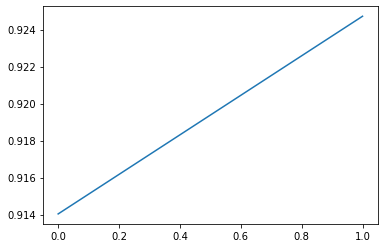

In [120]:
plt.plot(history.history['accuracy'])

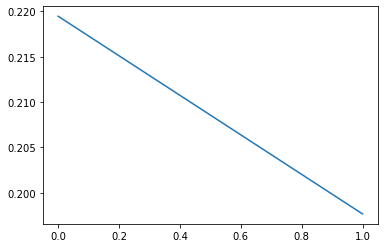

In [119]:
# codea aqui
plt1.plot(history.history['loss'])

### Analisis y discusión (20 puntos)
Realiza un analisis y explicación del ¿porque de tu modelo escogido?, ¿porque consideras que es bueno?, ¿en que piensas que falla?, ¿por que elgistes tal arquitectura?, ¿que recomendarías usar?

*** Hubo complicaciones porque en el tokenizer estaba mal la función para obtener el Y train, en donde daba 500 columnas, esto se arreglo y después se pudo hacer el entrenamiento, por otro lado la gráfica no se ve bien a mi parecer, sin embargo en la consola de accuracy y loss se muestra bien...***

# Arquitectura y Número de Parametros (30 puntos)
Sube una foto o escribe tu arquitectura. Además, por cada capa describe las dimensiones de entrada y de salida, las dimensiones de los parámetros, e hiperparametros. Guiate de la clase del sábado semana 05, y clase domingo semana 06. Después, calcula el número de parametros (no uses la misma libreria tensorflow, usa tu propio puño y letra) La siguientes imagenes  muestra un ejemplo: 
![picture](https://drive.google.com/uc?id=1ESAO1AuGLJjhfdhianQ8e4POcFFd40-v)
![picture](https://drive.google.com/uc?id=1UdcKArDgUYgJPVMlF9Cmpc-0rjGIrH5y)

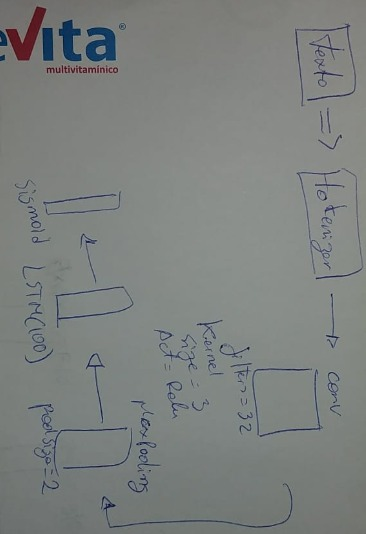